# Matched filter

An increase in flux from a point source (delta function) will result in power at all frequencies, with a phase that depends on where the source is. A simple search method is therefore simply to plot abs(V) vs. time and look for increases, probably with weighted averaging over $V_i$ visibilities at each time step. This says whether flux is varying, but not where that variation is.

To do this properly, including a model $V_{m,i}=f$, we should use a matched filter $h$ (e.g. see Loomis+2018 or wikipedia)
$$h = \frac{1}{\sqrt{f^* R_v^{-1} f}} R_v^{-1} f$$ 
where $R_v^{-1}$ is a diagonal matrix with $w_i$ if channels or time steps are not correlated. The $^*$ means conjugate transpose, so the normalisation is just a number.
For $s=1+0i$ (a point source) simplifies to
$$h = \frac{1}{\sqrt{\sum_i w_i}} w_i$$ 
and for equal weights and $w = 1/\sigma^2$
$$h = \frac{1}{ \sqrt{Nw}} w = \frac{\sqrt{w}}{N} = \frac{1}{\sqrt{N \sigma}}$$ 

We use the filter by summing over the data, and using the complex conjugate of $h$ (which is missed in Loomis+ eq 5 but noted as complex inner product in the text and done by `np.correlate`)
$$T = \sum_i V_i h^*$$
which for the equal weight point source is
$$T = \frac{1}{\sqrt{N}\sigma} \sum_i V_i$$
and if all $V_i$ were equal we would have
$$T = \frac{1}{\sqrt{N} \sigma} N V = \frac{\sqrt{N} V}{\sigma}$$
Which here just says that the signal to noise ratio goes up with the number of points averaged, as we expect.

From the above, to look for variation without specifying location we then want
$$\frac{\sum_i abs[V_i] w_i}{\sqrt{\sum_i w_i}}$$
because we all visbilities will increase with point source flux, but with phases that vary depending on where that source is. We want sum of absolute V, not absolute sum of V, because the latter would allow for cancellation when the phases are not all equal.

But to specify a location the phase matters, which is accounted for by taking the real component of $T$ and the sum uses the conjugate of $h$. The factor $\sqrt{2}$ normalises the real and imaginary components each to 1. For the idealised case of a point source at the phase center we would have
$$h = \frac{1}{\sqrt{\sum_i w_i}} w_i$$ 
and
$$T = Re[ \sqrt{2} \sum_i V_i h^* ]$$

For the full calculation that allows for an arbitrary model, but non-correlated channels/times we have
$$h = \frac{1}{\sqrt{f^* w f}} w f$$
but for a point source $f^* f$ is always 1 because only the phase shifts, and we can use
$$ h = \frac{1}{\sqrt{\sum_i w_i}} w f$$
and
$$T = Re[ \sqrt{2} \sum_i V_i h^* ]$$

To get a light curve in terms of flux, we want a weighted sum of the visibilities projected along the model visibilities.
$$f_{\nu}(t) = \frac{1}{\sum_i w_i} Re[ \sqrt{2} \sum_i V_i f_i^* w_i ]$$
the equations are slightly different to the matched filter as we need to multiply by the noise, or divide by square root of the weights
$$\frac{1}{\sqrt{\sum_i w_i}}$$


## Notes

Could do things per scan, since these might have a constant number of antennas so be reshapable to $N_{vis} \times N_{time}$, and hence $h$ calculation done once per scan rather than at every time step. This doesn't look like it works in practise, plus the uv change by more than about 1% per timestep.

The non-positional search is about a factor two less sensitive than the positional matched filter (based on Proxima).

uvmodelfit doesn't allow negative fluxes, so the SNR appears higher than with the matched filter because the rms is lower (essentially removing half the scatter).

In [2]:
import os
import numpy as np
import scipy.stats
import numexpr
import matplotlib.pyplot as plt
import matplotlib.animation
from galario import double as gd
from galario import arcsec
import tqdm

%load_ext line_profiler
%matplotlib notebook

In [3]:
# file = '/Users/grant/astro/projects/arks/data/HD15257.ACA.cal.bary.continuum.fav.corrected.ms.npy'
# file = '/Users/grant/astro/projects/arks/data/HD15257.12m.cal.bary.continuum.fav.corrected.ms.npy'
file = '/Users/grant/Library/CloudStorage/OneDrive-UniversityofWarwick/astro/projects/arks/data/proxima.ACA.npy'

In [4]:
filepath = os.path.dirname(file)
filename = os.path.basename(file).split('.npy')[0]
print(filepath)
print(filename)

/Users/grant/Library/CloudStorage/OneDrive-UniversityofWarwick/astro/projects/arks/data
proxima.ACA


In [5]:
# read vis 
u, v, Re, Im, w, time, scan = np.load(file)

time /= (24*60*60) # to MJD
times = np.unique(time)
times.sort()
scans = np.unique(scan)

vis = Re + 1j*Im
print(f'{vis.shape} visibilities')

(401760,) visibilities


In [26]:
ok = scan == 25
np.sum(ok)

56160

In [6]:
# reshaping ideas, not clear useful at all
# # see if we could reshape to nuv,nt
# print(f'{len(times)} time steps')
# try:
#     _ = vis.reshape((-1,len(times)))     
#     print(f'reshape to {_.shape}')
# except:
#     print('cannot reshape all to nvis x ntime')
    
# # if split into scans
# print(f'{len(scans)} scans')
# for s in scans:
#     ok = scan == s
#     print(f'n_u: {len(np.unique(u[ok]))}')
#     t_ = np.unique(time[ok])
#     n = len(t_)
#     try:
#         _ = vis[ok].reshape(((-1,n)))
#         print(f'scan {s} reshaped to {_.shape}')
#     except:
#         print(f'scan {s} ({len}) not reshaped {n,len(vis[ok])}')

In [7]:
# reweight visibilities so chi^2=1, assuming each V has 2 dof
rew = 2*len(w) / np.sum( (Re**2.0 + Im**2.0) * w )
print(rew)
w *= rew

0.3654488214444905


In [8]:
# reweighting as suggested by Loomis+
# unclear where factor 0.5 w.r.t. above comes from
# probably no of d.o.f
wgt_mean = np.mean(w)
data_std = np.std(vis)
rew = (1/data_std**2)/wgt_mean
print(rew)
w *= rew

0.48679261691225945


<IPython.core.display.Javascript object>


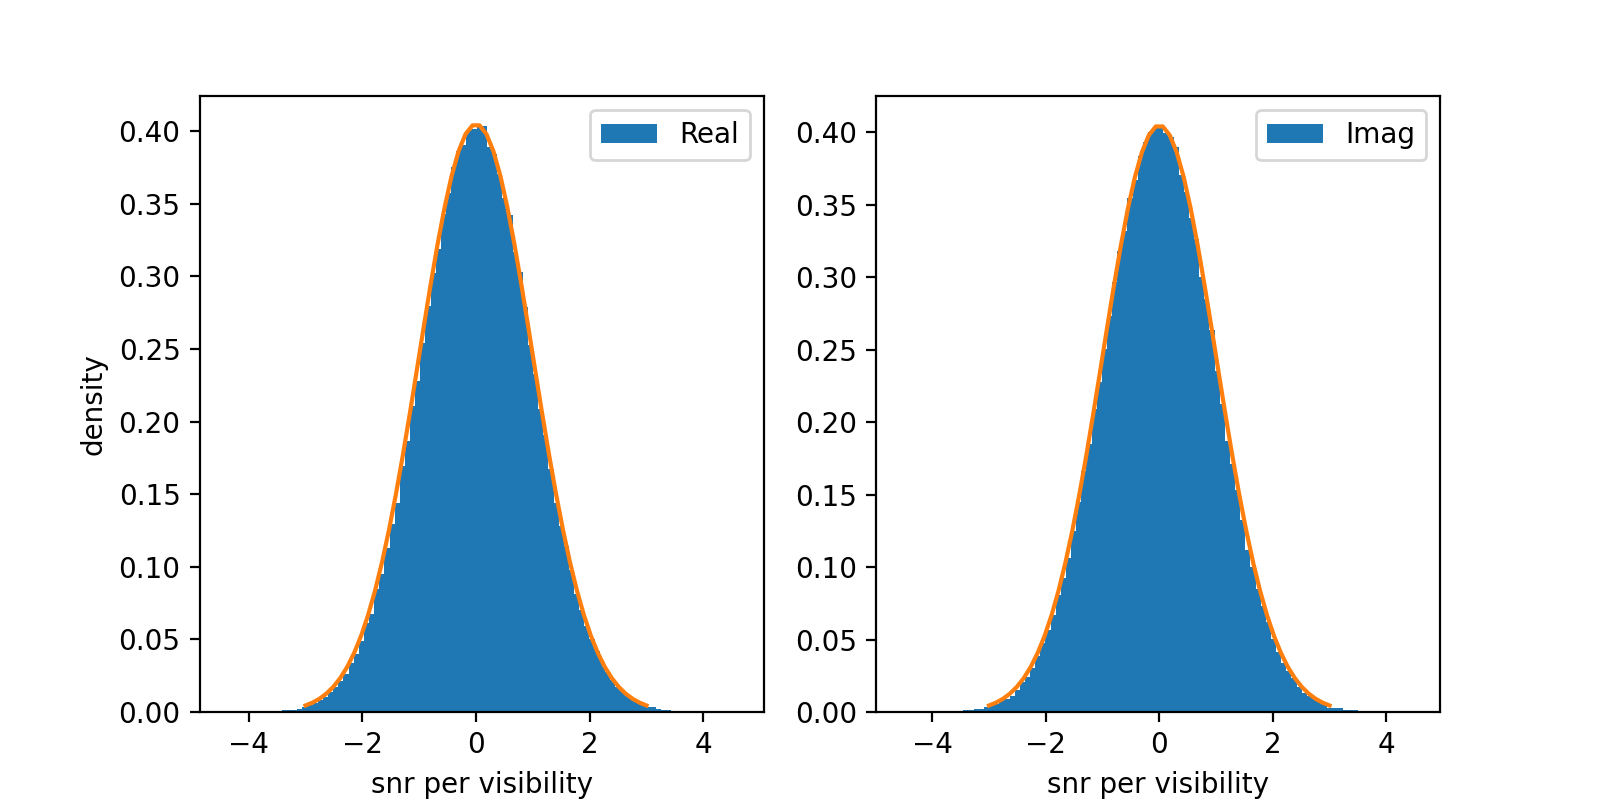

In [9]:
# check visiblity weights sensible
# multiply by sqrt(2) assuming Re and Im independent
fig, ax = plt.subplots(1, 2, figsize=(8,4))
_ = ax[0].hist(np.sqrt(2)*Re*np.sqrt(w), bins=100, density=True, label='Real')
_ = ax[1].hist(np.sqrt(2)*Im*np.sqrt(w), bins=100, density=True, label='Imag')
x = np.linspace(-3,3)
for a in ax:
    a.plot(x, np.max(_[0])*np.exp(-(x**2)/2))
    a.set_xlabel('snr per visibility')
    a.legend()
ax[0].set_ylabel('density')
fig.savefig(f'{filepath}/{filename}.vis_snr.png')

<IPython.core.display.Javascript object>


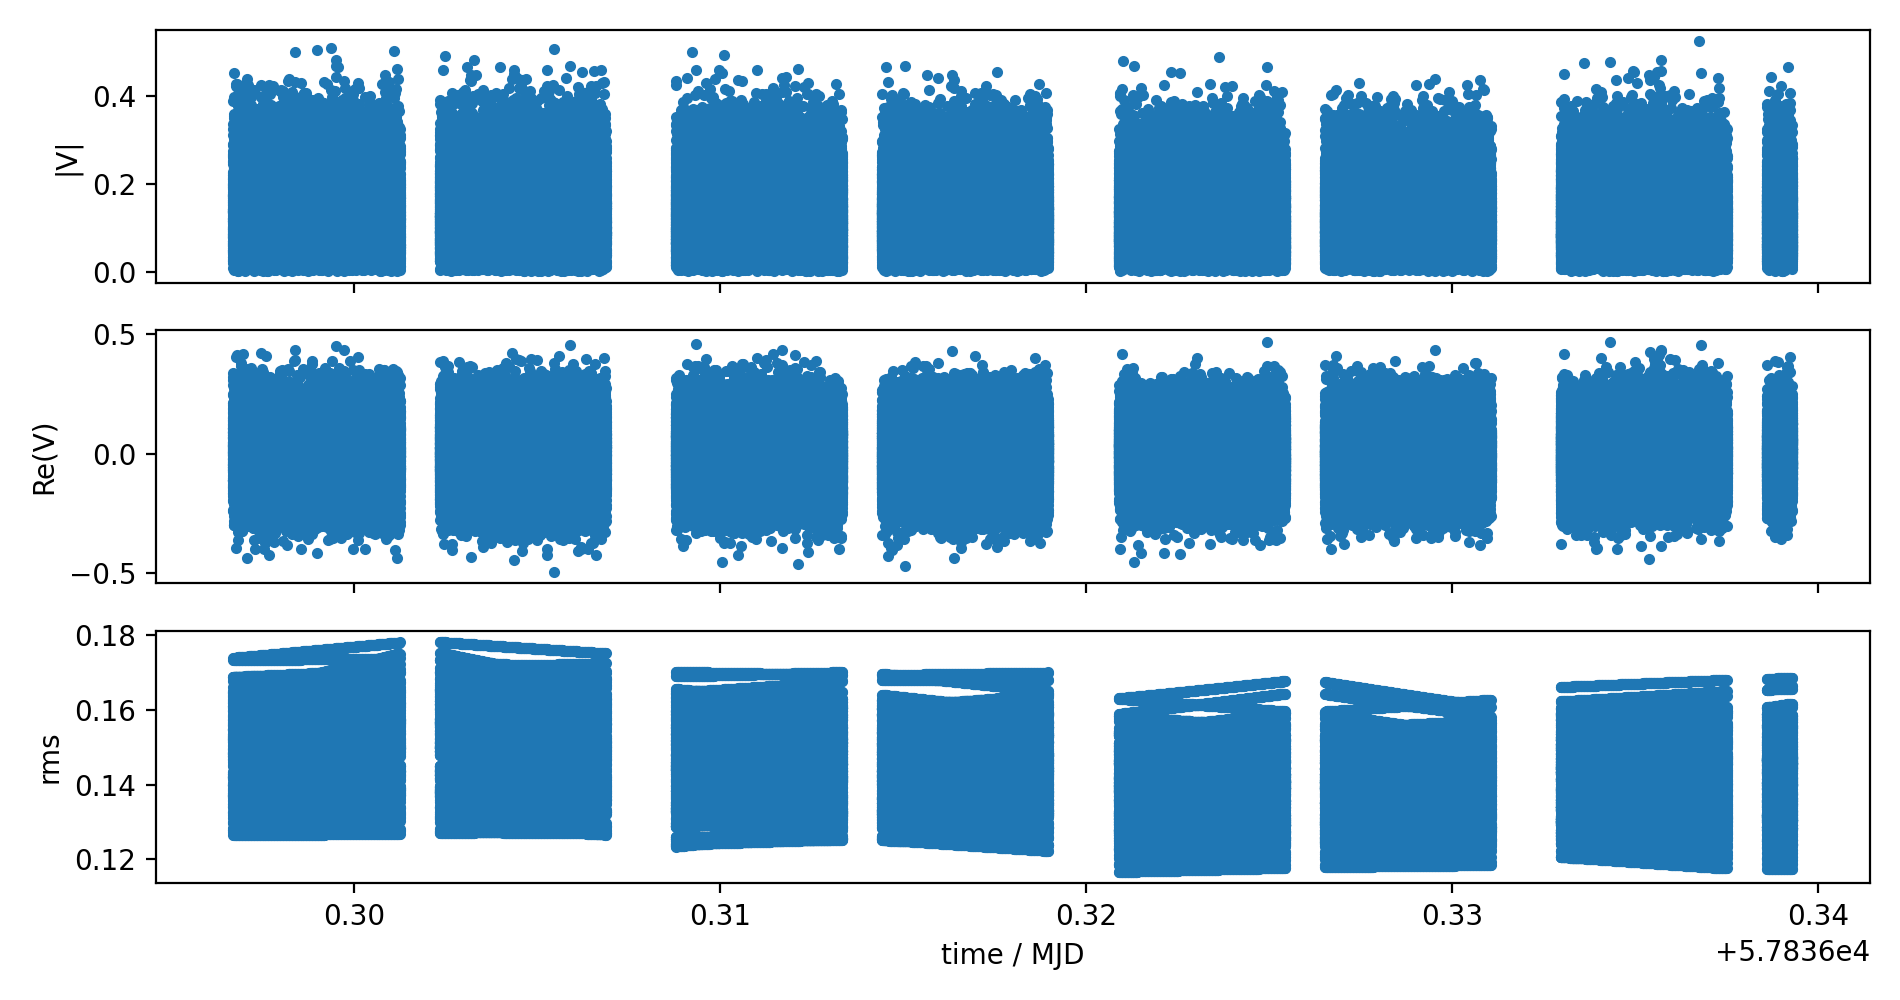

In [10]:
# observations over time
fig, ax = plt.subplots(3, figsize=(9.5,5), sharex=True)
ax[0].plot(time, np.abs(vis), '.')
ax[1].plot(time, Re, '.')
ax[2].plot(time, 1/np.sqrt(w), '.')
ax[0].set_ylabel('|V|')
ax[1].set_ylabel('Re(V)')
ax[2].set_ylabel('rms')
ax[2].set_xlabel('time / MJD')
fig.tight_layout()
fig.savefig(f'{filepath}/{filename}.vis_rms_time.png')

<IPython.core.display.Javascript object>


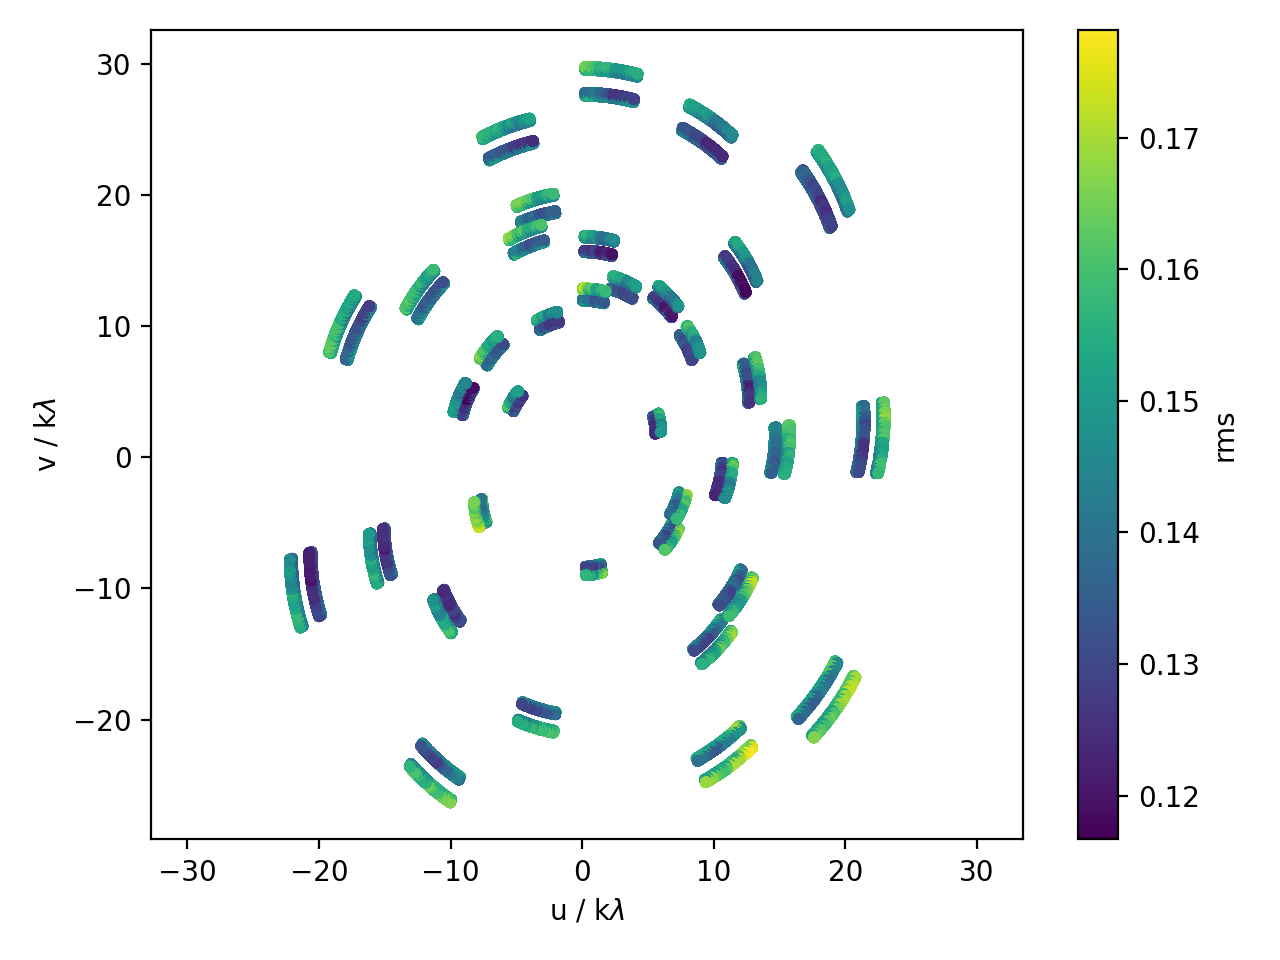

In [11]:
# take a look at uv coverage
fig, ax = plt.subplots()
m = ax.scatter(u/1e3, v/1e3, c=1/np.sqrt(w), marker='.')
ax.axis('equal')
ax.set_xlabel('u / k$\lambda$')
ax.set_ylabel('v / k$\lambda$')
_ = fig.colorbar(m)
_.set_label('rms')
fig.tight_layout()
fig.savefig(f'{filepath}/{filename}.uv.png')

In [15]:
def h_filter(vis_, wt):
    '''Return a matched filter for the visibilities and weights given.

    Assumes model is a point source, so norm and h are simplified. This
    makes things run much quicker.

    Parameters
    ---------
    vis_ : numpy array
        Model visibilities, 2d (nvis, npt)
    wt : numpy array
        Data weights, 1d (nvis)
    '''

#     R_inv = np.identity(len(wt))
    norm = 1/np.sqrt(np.sum(wt))
    if len(vis_.shape) == 1:
#         vis = vis_[:,np.newaxis]
#         norm = 1 / np.sqrt( np.matmul(vis.conj().T, np.matmul(wt*R_inv, vis)) ).squeeze()
#         h = norm * np.matmul(wt*R_inv, vis).squeeze()
        h = norm * wt * vis_
    else:
#         norm = 1 / np.sqrt(np.einsum('ij,ij->j', vis_.conj(), np.matmul(wt*R_inv, vis_)) )
#         h = norm * np.matmul(wt*R_inv, vis_)
        h = norm * wt[:,np.newaxis] * vis_

    return h,norm

In [16]:
# compute set of visibilities for our filter
# here point source at phase center so just np.ones(len(vis))
nxy, dxy = gd.get_image_size(u,v, verbose=True, f_max=2.5)
dxy_arcsec = dxy / arcsec

im = np.zeros((nxy,nxy))
im[nxy//2,nxy//2] = 1
ft = np.fft.fftshift(np.fft.fft2(im))

vis_mod = gd.sampleImage(im, dxy, u, v)
print(vis_mod)

# fig, ax = plt.subplots(1,3, figsize=(9.5,3.5))
# ax[0].imshow(im)
# ax[1].imshow( np.abs(ft) )
# ax[2].imshow( np.angle(ft) )
# fig.tight_layout()

dxy:8.276235e-01arcsec	nxy_MRS:128
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:2.118716e+01arcsec
[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.-0.j]


In [17]:
# single-position matched filter
ok = time == times[0]

# basic version for point source with V_mod=1+0j as above
print((vis_mod[ok] * w[ok] / np.sqrt(np.sum(w[ok])))[:10])
print(1/np.sqrt(np.sum(w[ok])))

# check against proper function
# %timeit h_, _ = h_filter(vis_mod[ok], w[ok])
h_, _ = h_filter(vis_mod[ok], w[ok])
print(h_[:10],_)

# 2d version
# h_, _ = h_filter(vis_mod[ok,np.newaxis], w[ok])
# %timeit h_filter(np.vstack((vis_mod[ok],vis_mod[ok])).T, w[ok])
h_, _ = h_filter(np.vstack((vis_mod[ok],vis_mod[ok])).T, w[ok])
print(h_[:10],_)

[0.61210259+0.j 0.6612894 +0.j 0.53618177+0.j 0.6137151 +0.j
 0.56997626+0.j 0.6415143 +0.j 0.54433187+0.j 0.60927899+0.j
 0.64754084+0.j 0.52546177+0.j]
0.01229156172855598
[0.61210259+0.j 0.6612894 +0.j 0.53618177+0.j 0.6137151 +0.j
 0.56997626+0.j 0.6415143 +0.j 0.54433187+0.j 0.60927899+0.j
 0.64754084+0.j 0.52546177+0.j] 0.01229156172855598
[[0.61210259+0.j 0.61210259+0.j]
 [0.6612894 +0.j 0.6612894 +0.j]
 [0.53618177+0.j 0.53618177+0.j]
 [0.6137151 +0.j 0.6137151 +0.j]
 [0.56997626+0.j 0.56997626+0.j]
 [0.6415143 +0.j 0.6415143 +0.j]
 [0.54433187+0.j 0.54433187+0.j]
 [0.60927899+0.j 0.60927899+0.j]
 [0.64754084+0.j 0.64754084+0.j]
 [0.52546177+0.j 0.52546177+0.j]] 0.01229156172855598


In [78]:
times_ = np.unique(time)
h = 1/np.sqrt(vis_mod.conjugate() * w * vis_mod) * w * vis_mod
times = []
scans = []
v_re = []
v_abs = []
n = 1
for i in tqdm.tqdm(range(len(times_)-n+1)):
#     ok = time == times[i]
    ok = (times_[i] <= time) & (time <= times_[i+n-1])
    scans.append(scan[ok][0])
    times.append(np.mean(time[ok]))
    
    v_abs.append( np.dot( np.abs(vis[ok]), np.sqrt(w[ok]) ) )     # no position
    
    h_, _ = h_filter(vis_mod[ok], w[ok])
    v_re.append( np.sqrt(2) * np.dot( vis[ok], h_.conj() ) )

times = np.array(times)
v_abs = np.array(v_abs)
v_re = np.real(np.array(v_re))

100%|██████████████████████████████████████| 2790/2790 [00:03<00:00, 876.35it/s]


In [79]:
smth = np.convolve(v_re, np.repeat(1,14)/14, mode='same')

In [80]:
# compare rms and snr
ok = (times > 57836.3) & (times < 57836.33)

print(np.mean(np.abs(v_abs[ok])),np.std(np.abs(v_abs[ok])))
print(np.mean(v_re[ok]),np.std(v_re[ok]))
print(np.std(smth[ok]))

print( 'abs:', (np.max(v_abs)-np.mean(v_abs[ok]))/np.std(v_abs[ok]) )
print( 're:', (np.max(v_re)-np.mean(v_re[ok]))/np.std(v_re[ok]) )
print( 'sm:', (np.max(smth)-np.mean(smth[ok]))/np.std(smth[ok]) )

125.6052117707246 5.493121457673352
0.049545087245125255 1.0039724256409428
0.27635402866674313
abs: 7.147090826661378
re: 14.417566901129918
sm: 40.73010501330993


In [81]:
# compare with uvmodelfit output
# d = np.load('/Users/grant/astro/data/alma/proxima/timeflux.npy')
d = np.load('/Users/grant/astro/data/alma/proxima/uid___A002_Xbe43ba_X79e6.ms.split.cal.var/scans/29/timeflux.npy')
# d[0] = d[0]/2
ok = (d[0] > 57836.326) & (d[0] < 57836.3348)
print(np.std(d[1][ok]))

print( 'uvmodelfit:', (np.max(d[1])-np.mean(d[1][ok]))/np.std(d[1][ok]) )

0.003526532264645834
uvmodelfit: 27.06287301499645


In [82]:
smth_uv = np.convolve(d[1], np.repeat(1,7)/7, mode='same')
print(np.std(smth_uv[ok]))

print( 'uvmodelfit:', (np.max(smth_uv)-np.mean(smth_uv[ok]))/np.std(smth_uv[ok]) )

0.001611857197536909
uvmodelfit: 55.23407962968871


<IPython.core.display.Javascript object>


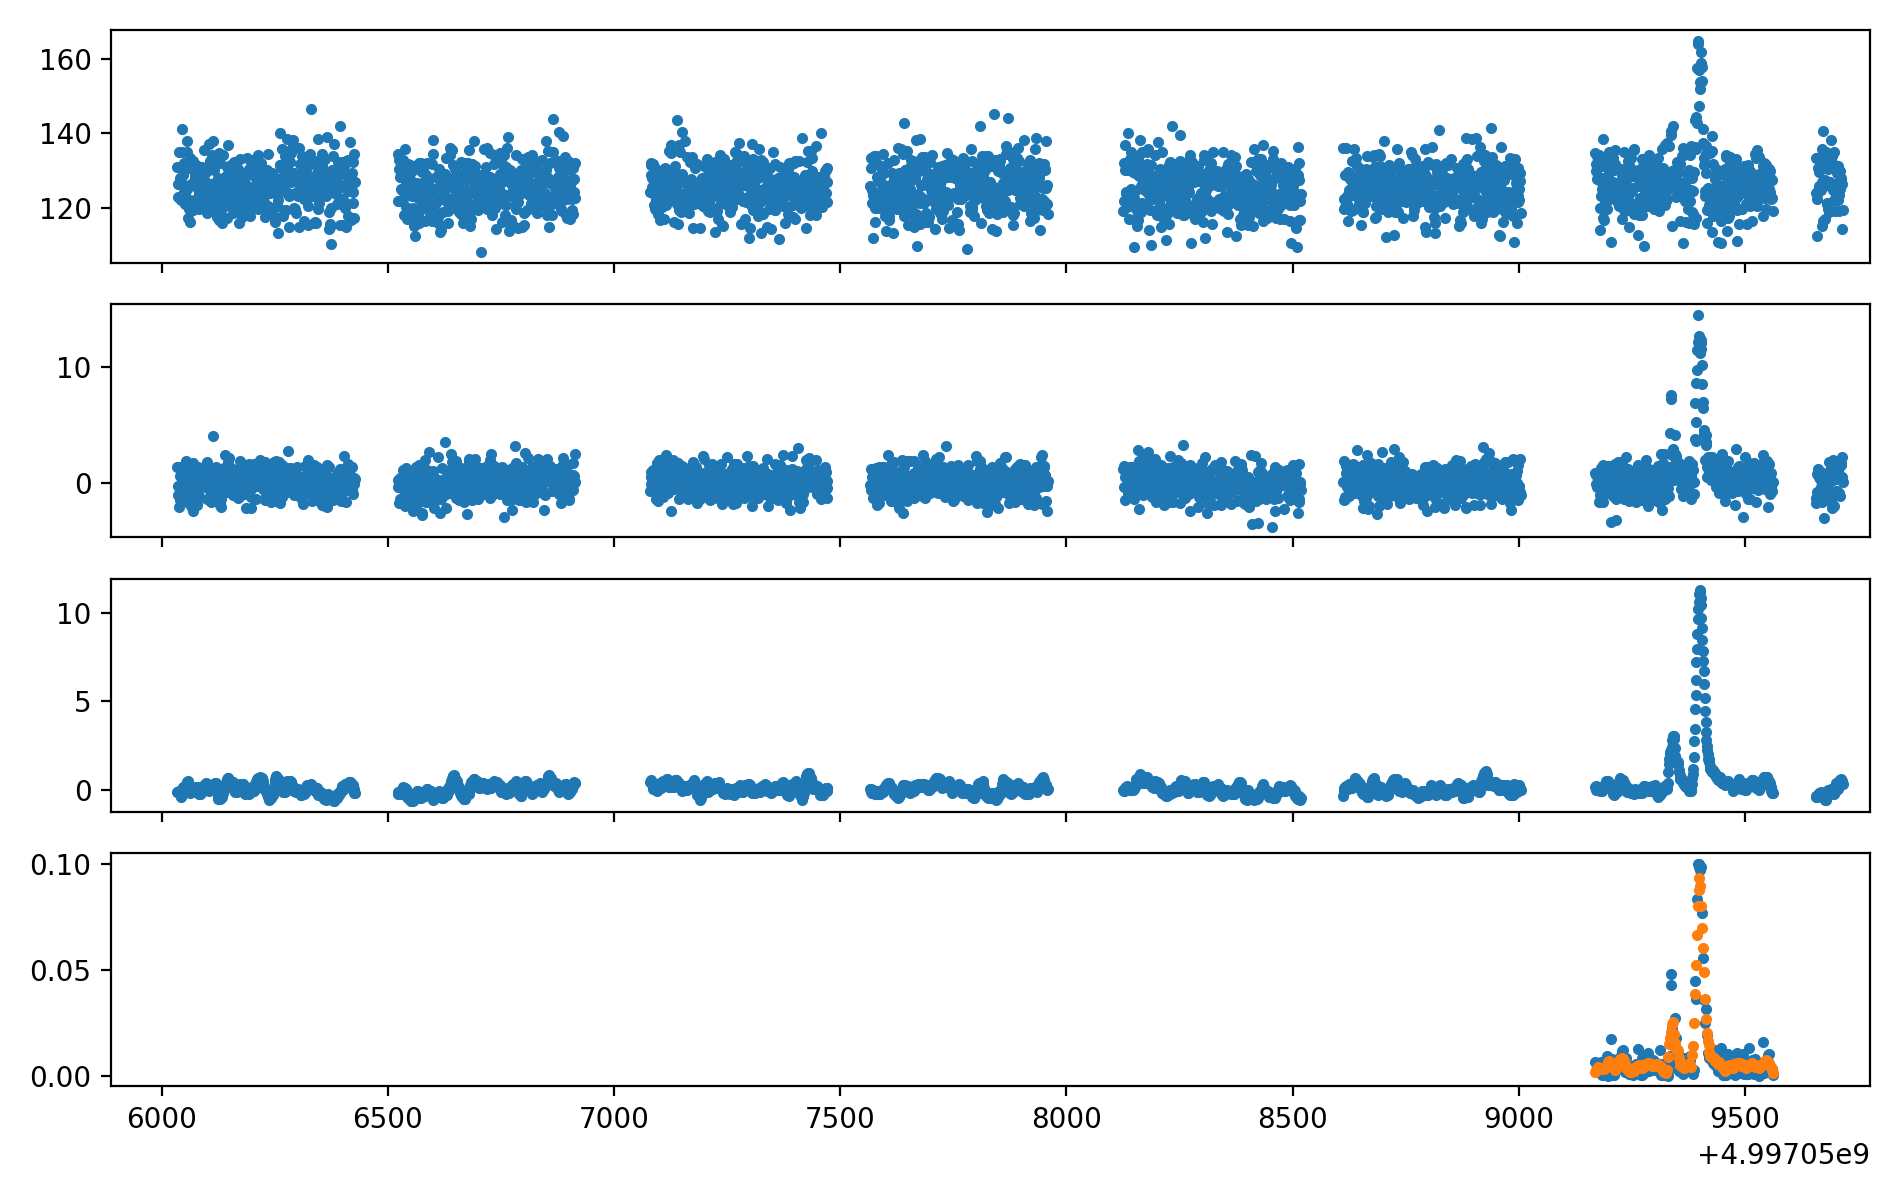

In [83]:
fig, ax = plt.subplots(4, sharex=True, figsize=(9.5,6))
ax[0].plot(times*24*60*60, np.abs(v_abs), '.')
ax[1].plot(times*24*60*60, v_re, '.')
ax[2].plot(times*24*60*60, smth, '.')
ax[3].plot(d[0]*24*60*60, d[1], '.')
ax[3].plot(d[0]*24*60*60, smth_uv, '.')
ax[0].set_xlim(57836.295*24*60*60, 57836.34*24*60*60)
fig.tight_layout()

<IPython.core.display.Javascript object>


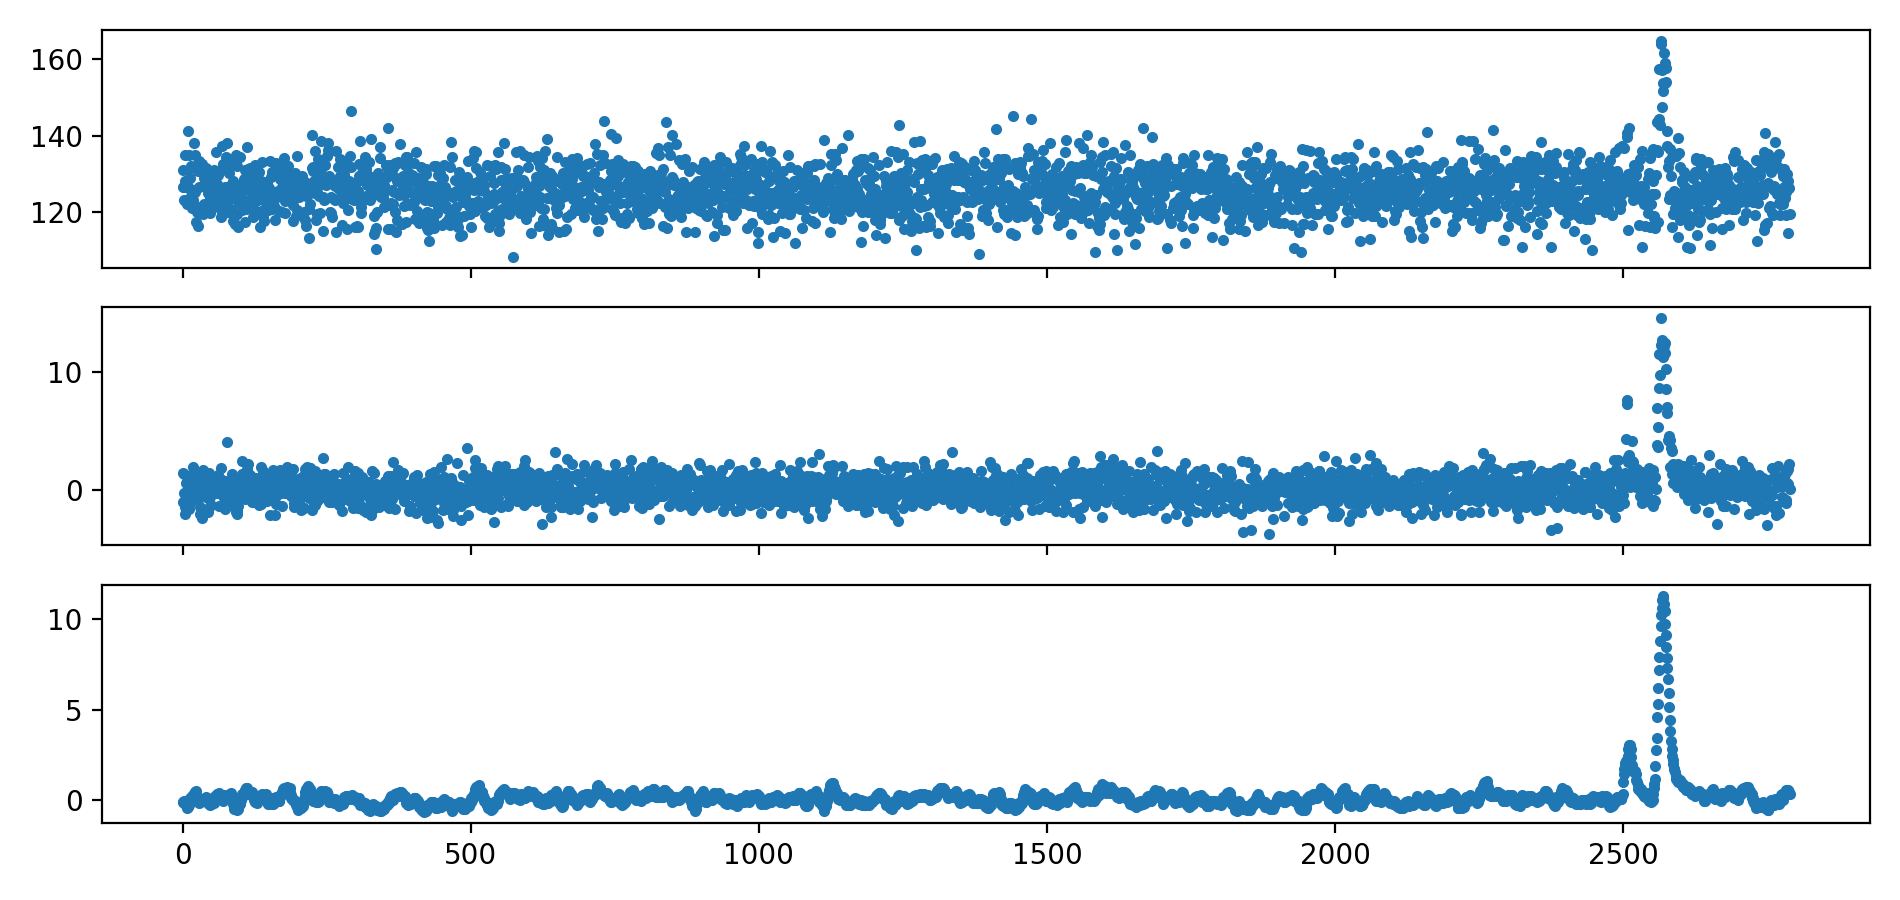

In [24]:
fig, ax = plt.subplots(3, sharex=True, figsize=(9.5,4.5))
ax[0].plot(np.abs(v_abs), '.')
ax[1].plot(v_re, '.')
ax[2].plot(smth, '.')
fig.tight_layout()

<IPython.core.display.Javascript object>


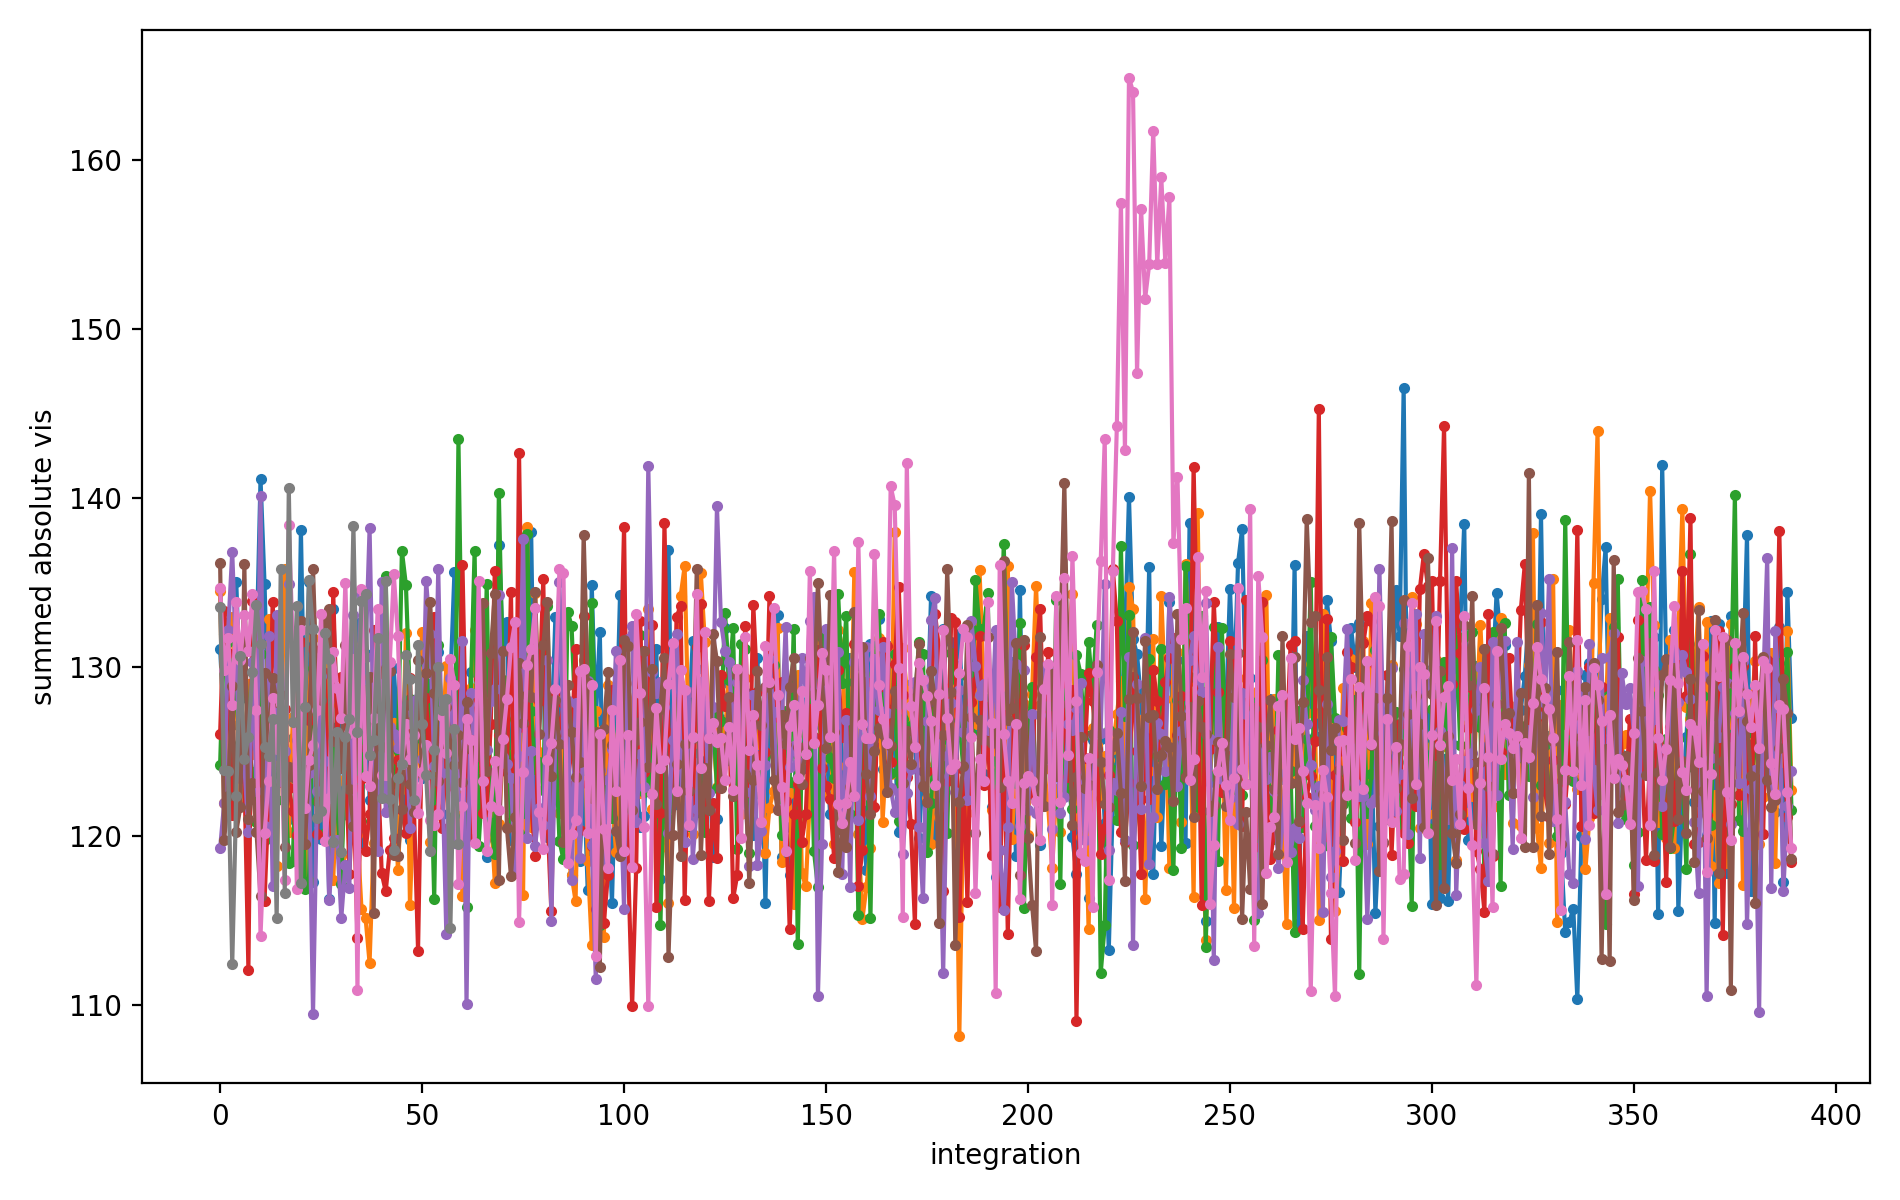

In [21]:
fig, ax = plt.subplots(figsize=(9.5,6))

for i,s in enumerate(np.unique(scans)):
    ok = scans == s
    ax.plot(np.abs(v_abs[ok]), '.-')
    
ax.set_xlabel('integration')
ax.set_ylabel('summed absolute vis')
fig.tight_layout()
fig.savefig(f'{filepath}/{filename}.snr.absvis.png')

<IPython.core.display.Javascript object>


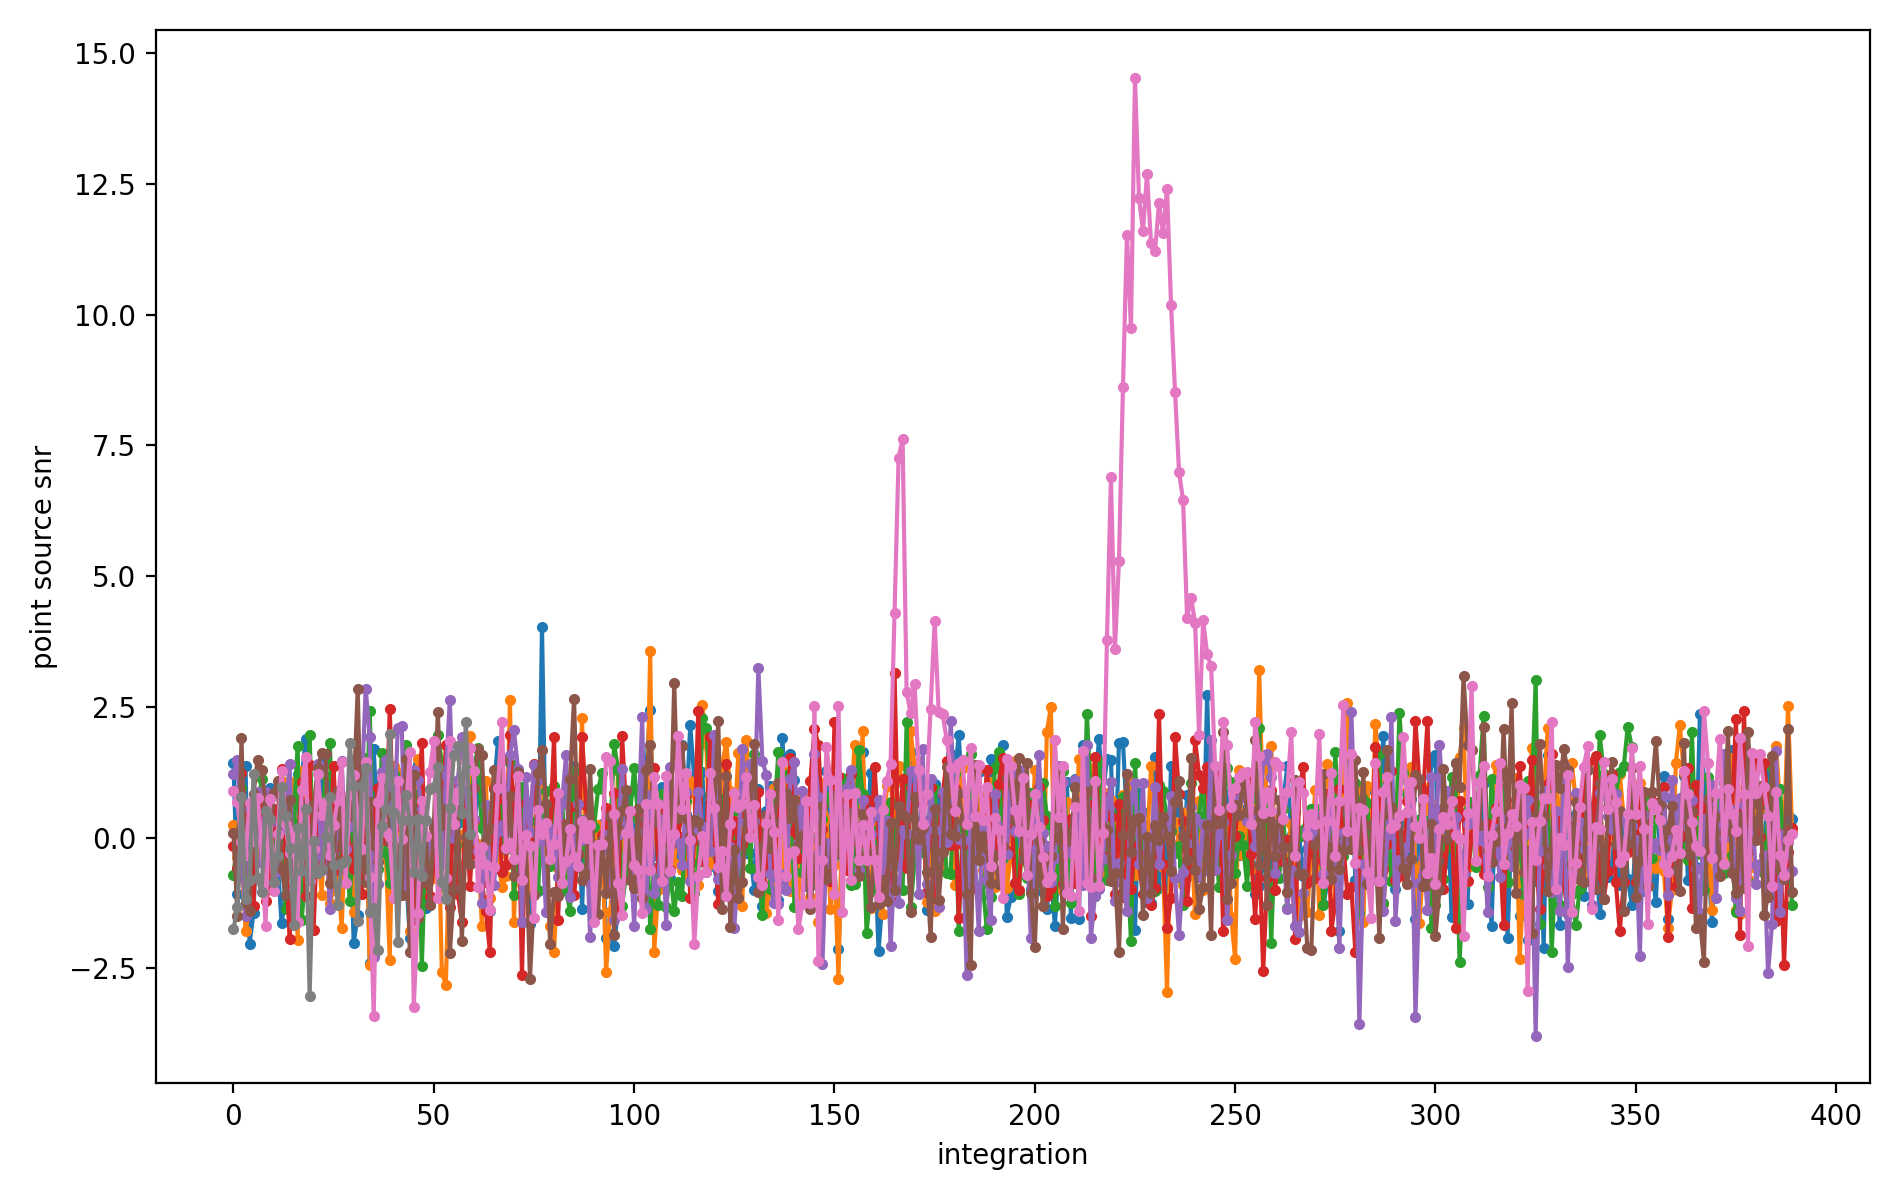

In [22]:
fig, ax = plt.subplots(figsize=(9.5,6))

for i,s in enumerate(np.unique(scans)):
    ok = scans == s
    ax.plot(v_re[ok], '.-')
    
ax.set_xlabel('integration')
ax.set_ylabel('point source snr')
fig.tight_layout()
fig.savefig(f'{filepath}/{filename}.snr.phasecen.png')

In [157]:
nw = 30
ws = np.arange(nw)+1

T = np.zeros((nw,len(times)))
wpk = []
pk = []

for i,wi in enumerate(ws):
    T[i] = np.convolve(v_re, np.repeat(1,wi)/wi, mode='same')
    T[i] *= np.sqrt(wi)
#     ok = T[i] < 4
#     T[i] -= np.median(T[i,ok])
#     T[i] /= np.std(T[i,ok])
    ok = np.where(T[i] > 3)[0]
    for o in ok:
        wpk.append(wi)
        pk.append(o)
        
wpk = np.array(wpk)
pk = np.array(pk)

1 2790 2790
2 2789 2790
3 2788 2790
4 2787 2790
5 2786 2790
6 2785 2790
7 2784 2790
8 2783 2790
9 2782 2790
10 2781 2790
11 2780 2790
12 2779 2790
13 2778 2790
14 2777 2790
15 2776 2790
16 2775 2790
17 2774 2790
18 2773 2790
19 2772 2790
20 2771 2790
21 2770 2790
22 2769 2790
23 2768 2790
24 2767 2790
25 2766 2790
26 2765 2790
27 2764 2790
28 2763 2790
29 2762 2790
30 2761 2790


In [158]:
Ti = np.argmax(T)
xy = np.unravel_index(Ti, T.shape)
print(xy, T[xy])

(29, 2569) 1177.963702294462


<IPython.core.display.Javascript object>


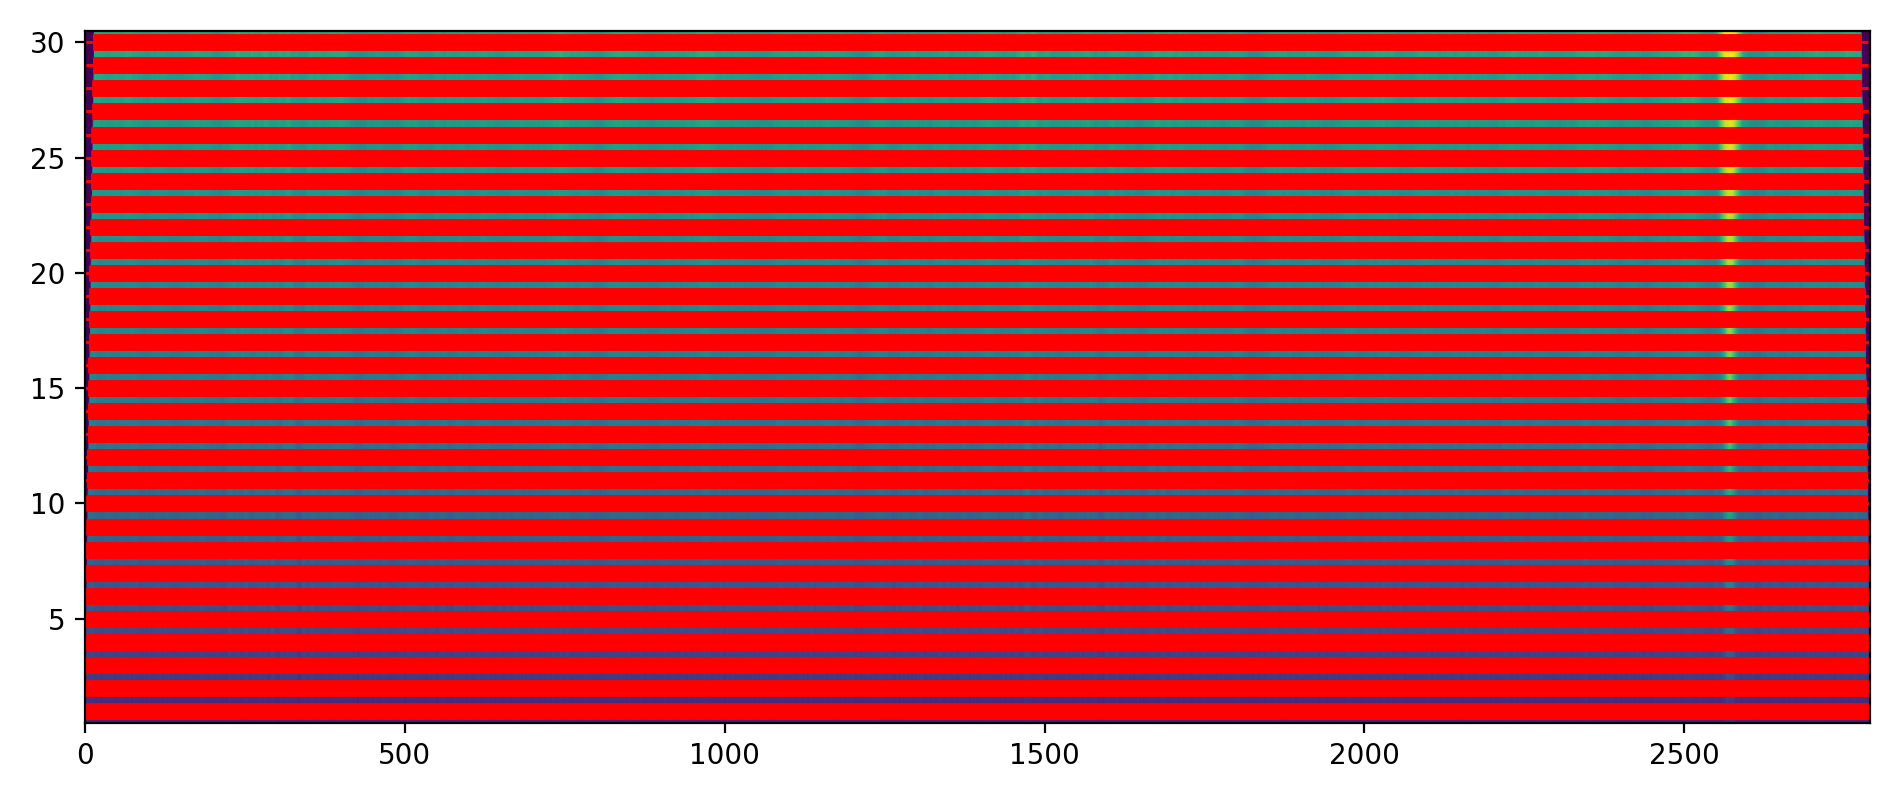

In [159]:
fig, ax = plt.subplots(figsize=(9.5,4))
ax.imshow(T, aspect='auto', origin='lower', extent=(0,len(times),0.5,np.max(ws)+0.5))
ax.plot(pk, wpk, '+r')
fig.tight_layout()

### What does the v_abs distribution look like?
This distribution cannot be Gaussian, but can we characterise it with something else?

125.75878534692936
(125.88475294443826, 5.905070497783196)
139.62200114301748
(125.60787468345178, 5.3499776945943776)


<IPython.core.display.Javascript object>


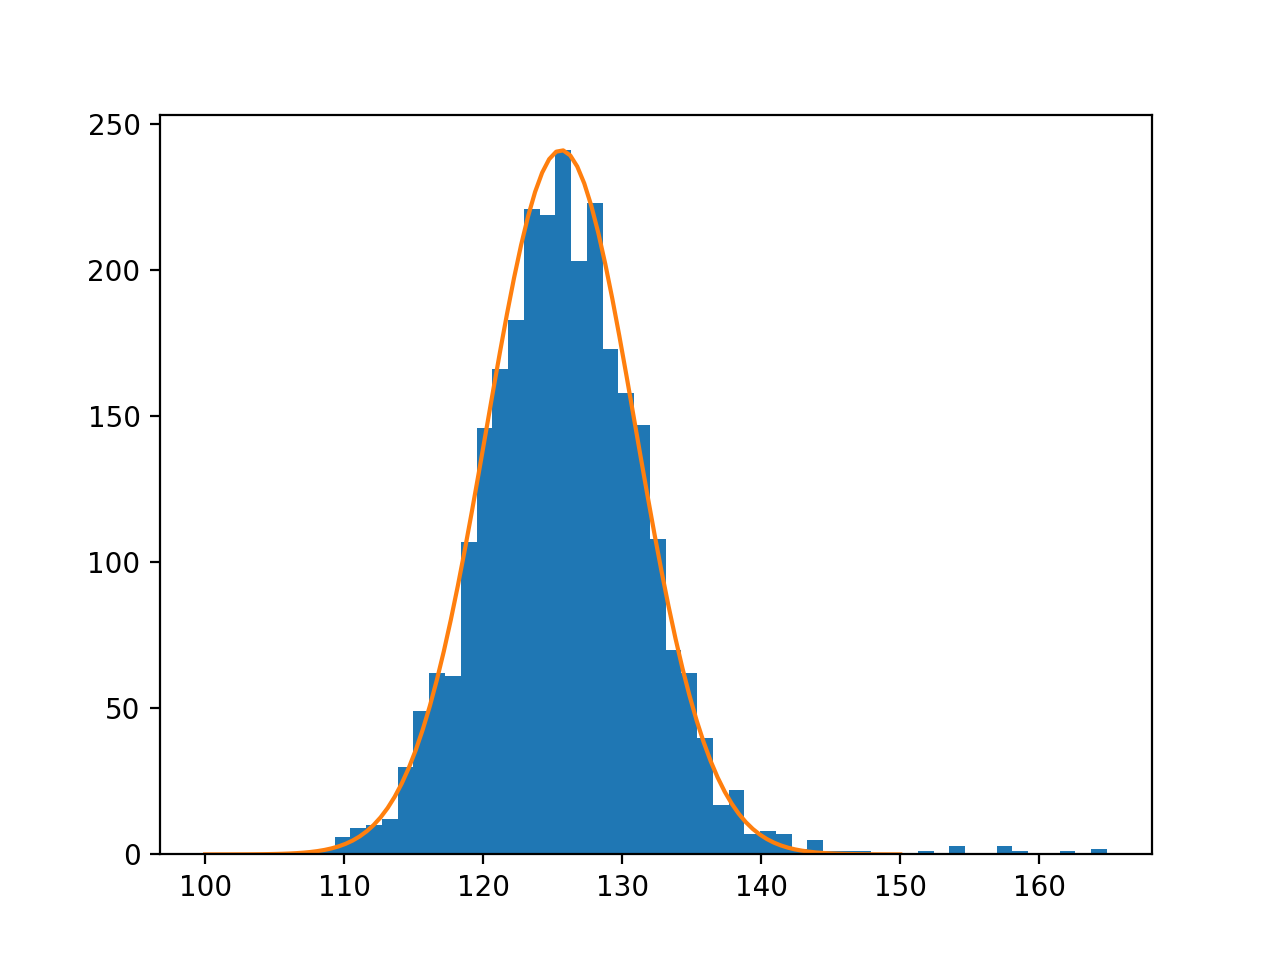

In [26]:
model = scipy.stats.norm
dist = np.abs(v_abs)
print(np.median(dist))
par = model.fit(dist)
print(par)
cut = model.ppf(0.99, *par)
print(cut)
par = model.fit(dist[dist<cut])
print(par)

fig, ax = plt.subplots()
_ = ax.hist(dist, bins=50)
x = np.linspace(100,150, 100)
pdf = model.pdf(x, *par)#, loc=0, scale=8.5)
ax.plot(x, pdf/np.max(pdf)*np.max(_[0]))
# ax.set_xlim(0,cut*1.2)


model_dist = model.rvs(*par, size=10000)
# _ = ax.hist(model_dist, bins=100, alpha=0.5)

### multi-position filter

In [48]:
# lower expectations on spatial resolution
nxy = 20

dxy_arcsec = 0.5
dxy = dxy_arcsec * arcsec
print(dxy,dxy_arcsec)

2.42406840554768e-06 0.5


<IPython.core.display.Javascript object>


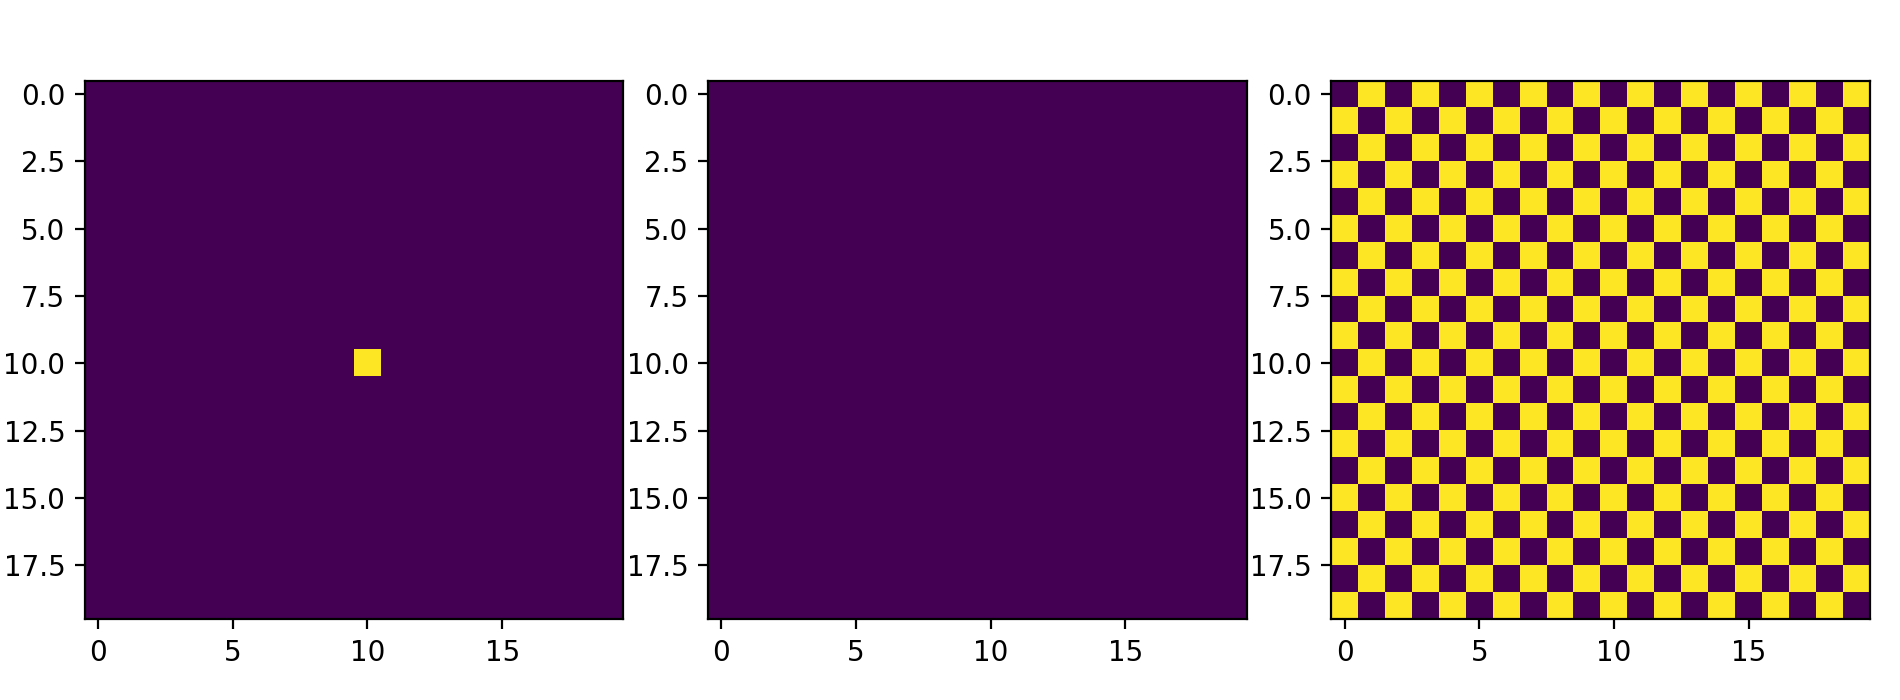

In [49]:
# check middle is where we think it is
# FT should have zero phase everywhere
xy_pix = (np.arange(nxy) - nxy/2)
xy = xy_pix * dxy
yy, xx = np.meshgrid(xy, xy)

im = np.zeros((nxy,nxy))
im[(yy==0) & (xx==0)] = 1
ft = np.fft.fftshift(np.fft.fft2(im))

fig, ax = plt.subplots(1,3, figsize=(9.5,3.5))
ax[0].imshow(im)
ax[1].imshow( np.abs(ft) )
ax[2].imshow( np.angle(ft) )
fig.tight_layout()

In [40]:
def shift(u, v, x, y, flatxy=True, nex=True):
    '''Shifts for x by y shifts and len(uv), returns nvis x nx'''
    out = np.outer(u, x) + np.outer(v, y)
    arg = -2*np.pi*1j*out
    if nex:
        a = numexpr.evaluate('exp(arg)')
    else:
        a = np.exp(arg)
    if flatxy:
        return a.squeeze()
    else:
        return a.reshape((-1,)+x.shape)

ok = time == np.min(time)

# %timeit shift(u[ok], v[ok], xx, yy, nex=False)
# %timeit shift(u[ok], v[ok], xx, yy, nex=True)

a = shift(u[ok], v[ok], xx, yy, flatxy=False)
a.shape

(144, 40, 40)

In [41]:
# check on different shift methods
im = np.zeros((nxy,nxy))
im[nxy//2,nxy//2+1] = 1
vis_mod = gd.sampleImage(im, dxy, u, v)
print(vis_mod)

im = np.zeros((nxy,nxy))
im[nxy//2,nxy//2] = 1
vis_mod1 = gd.sampleImage(im, dxy, u, v, dRA=-dxy)
print(np.sum(vis_mod-vis_mod1))

im = np.ones((nxy,nxy), dtype=complex)
vis_mod2 = shift(u, v, np.array(dxy), np.array(0))
print(np.sum(vis_mod-vis_mod2))

[1.-3.17839195e-12j 1.-9.52272365e-14j 1.-1.23223981e-13j ...
 1.-1.32814965e-11j 1.-1.19982518e-11j 1.+1.28324464e-12j]
1.5935191424868401e-09j
1.5935191424868449e-09j


In [50]:
times = np.unique(time)
scans = []
v_pos = []

for t in tqdm.tqdm(times):

    ok = time == t
    scans.append(scan[ok][0])
    
    vis_mod = shift(u[ok], v[ok], xx, yy, flatxy=True)
    h,_ = h_filter(vis_mod, w[ok])
    v_pos.append( np.sqrt(2) * np.einsum('i,ij->j', vis[ok], h.conjugate()) )
#     v_pos.append( np.sqrt(2) * np.sum(vis[ok] * h.conjugate().T, axis=1) ) # no faster/slower

v_pos = np.array(v_pos).reshape((-1,)+xx.shape)
v_re = np.real(v_pos)

100%|██████████████████████████████████████| 2790/2790 [00:03<00:00, 845.01it/s]


In [32]:
# where does the time go?
%timeit shift(u[ok], v[ok], xx, yy, flatxy=True)
%timeit h_filter(vis_mod, w[ok])
%timeit np.sqrt(2) * np.einsum('i,ij->j', vis[ok], h.conjugate())
a = vis[ok]
b = h.conj().T
%timeit np.sqrt(2) * numexpr.evaluate('sum(a*b, axis=1)')

512 µs ± 3.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
145 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
261 µs ± 4.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
123 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [33]:
np.save(f'{filepath}/{filename}.v_pos.npy', v_pos)

<IPython.core.display.Javascript object>


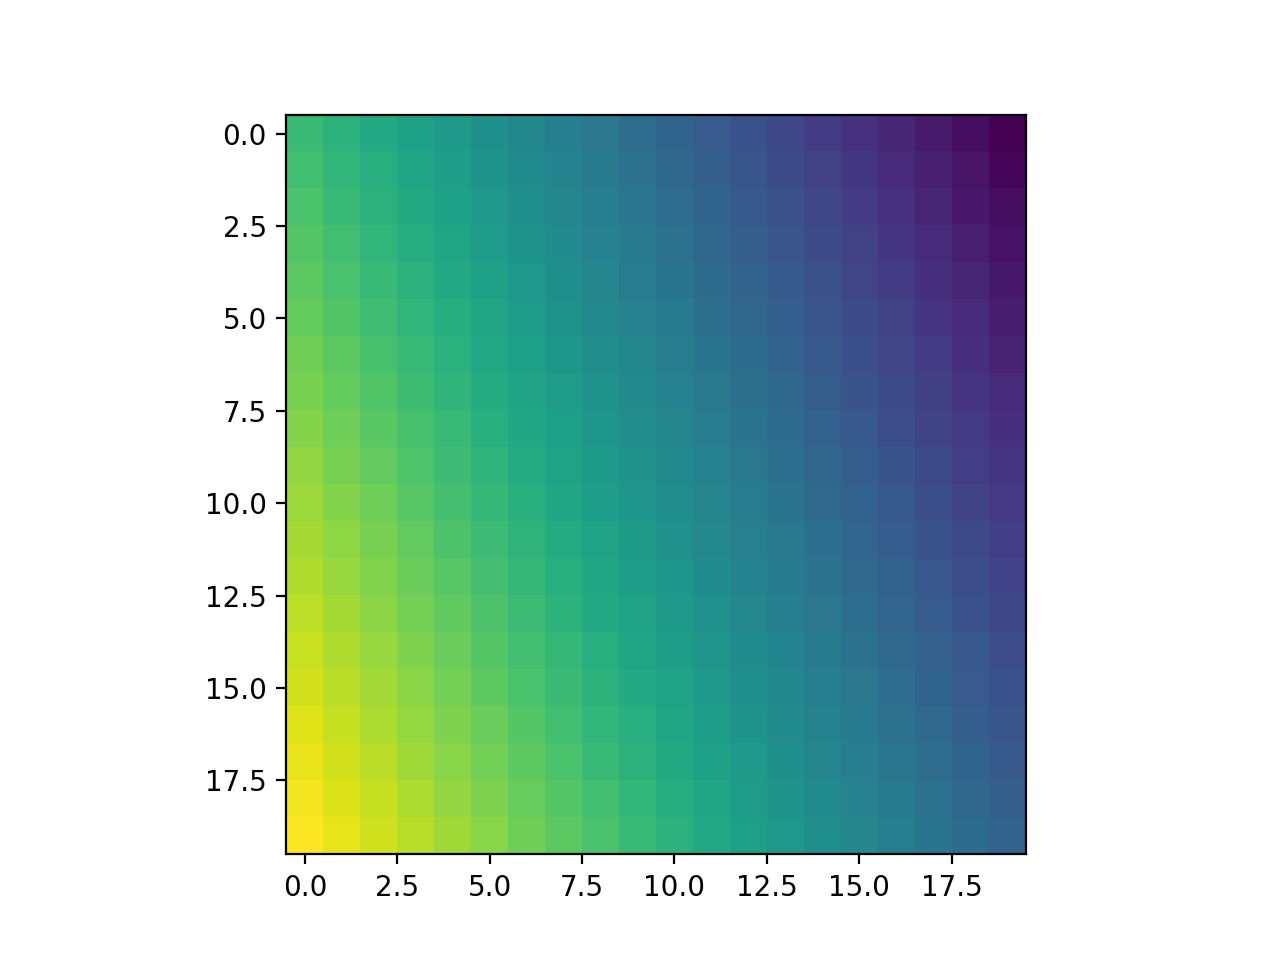

In [34]:
fig, ax = plt.subplots()

ims = []
for i in range(len(v_re)):
    im = ax.imshow(v_re[i], animated=True)
    if i == 0:
        ax.imshow(v_re[0])  # show an initial one first
    ims.append([im])
    
ani = matplotlib.animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                           repeat_delay=1000)

In [35]:
ani.save(f'{filepath}/{filename}.v_pos.mp4', writer=matplotlib.animation.FFMpegWriter())

In [51]:
# see if we can find the flare
rms = np.std(v_re[:-300], axis=0)
max = np.max(v_re, axis=0)
print(rms,rms.shape)

[[0.99588449 0.99542406 0.99386747 0.99210632 0.99129345 0.99228056
  0.99510436 0.99877224 1.00149105 1.00128673 0.99679191 0.98791191
  0.97610697 0.96411756 0.95512117 0.95157184 0.95424493 0.96201893
  0.97251513 0.98317549]
 [0.99694918 0.99645849 0.99486598 0.99316019 0.99257249 0.99399271
  0.99744206 1.00186127 1.00535764 1.00585113 1.00188608 0.99331237
  0.98157475 0.96944079 0.96015769 0.95628484 0.95871715 0.96642982
  0.97707605 0.98803435]
 [0.99763979 0.99716552 0.99566016 0.99409776 0.99369938 0.99536527
  0.99914924 1.00403203 1.00814599 1.009403   1.00629838 0.99859464
  0.98762157 0.97602495 0.96695578 0.96294065 0.96492655 0.972008
  0.98197001 0.99227309]
 [0.99783196 0.9975953  0.99641729 0.99515011 0.99492966 0.996653
  1.00046045 1.00547437 1.00996483 1.0119225  1.00983131 1.0033472
  0.99361362 0.98304338 0.97456128 0.97054221 0.97191096 0.97787573
  0.98642006 0.99521161]
 [0.99737174 0.99772982 0.99719763 0.99641744 0.9963892  0.99800768
  1.00155076 1.006365

<IPython.core.display.Javascript object>


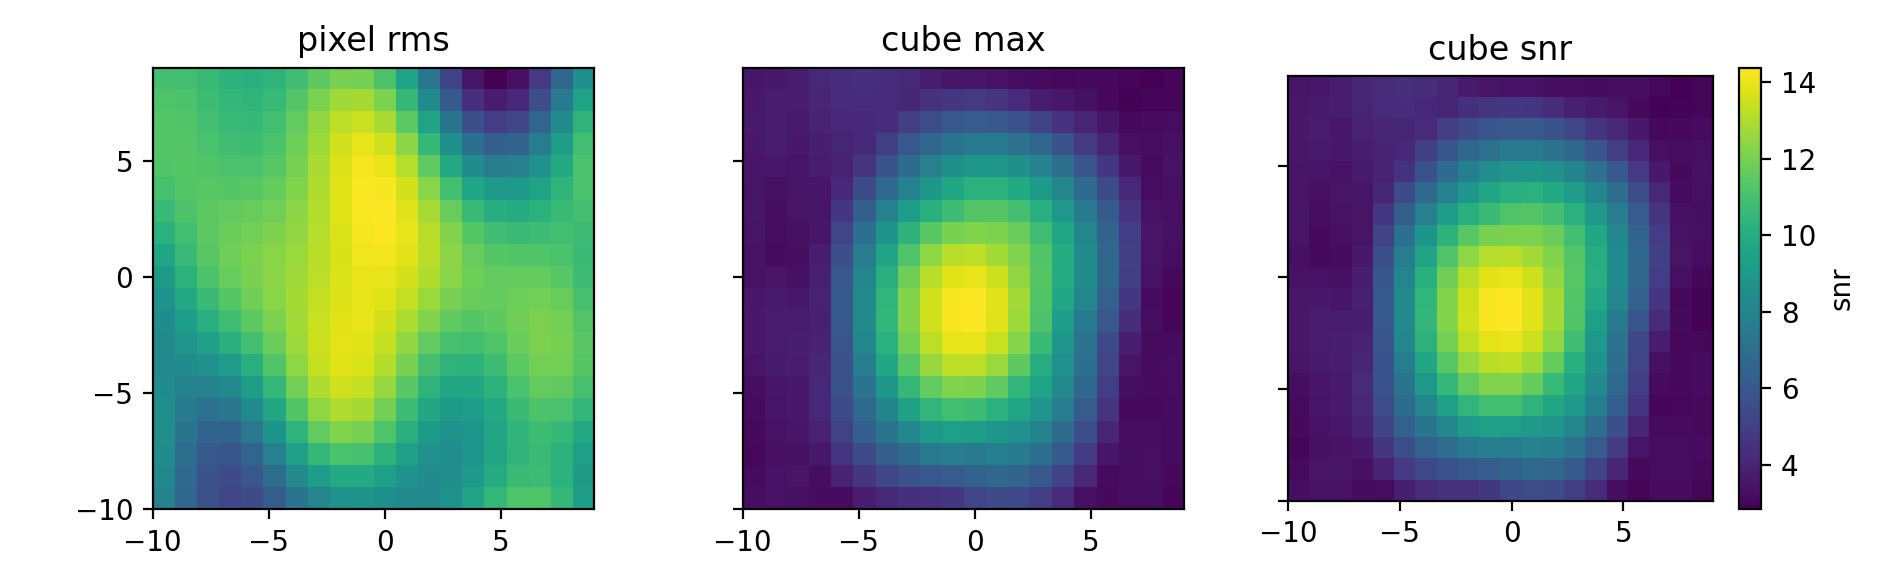

In [52]:
fig, ax = plt.subplots(1,3, figsize=(9.5,2.9), sharex=True, sharey=True)
ax[0].imshow(rms, extent=[np.min(xy_pix),np.max(xy_pix),np.min(xy_pix),np.max(xy_pix)])
ax[1].imshow(max, extent=[np.min(xy_pix),np.max(xy_pix),np.min(xy_pix),np.max(xy_pix)])
_ = ax[2].imshow(max/rms, extent=[np.min(xy_pix),np.max(xy_pix),np.min(xy_pix),np.max(xy_pix)])
_ = fig.colorbar(_)
_.set_label('snr')
for a,l in zip(ax,['pixel rms','cube max','cube snr']):
    a.set_title(l)
    
fig.tight_layout()
fig.savefig(f'{filepath}/{filename}.v_pos.png')